In [12]:
import sys
sys.path.insert(0, "/Users/aimachine/PyImage/utils")
import numpy as np
from PIL import Image
import os
from tifffile import imread
import matplotlib.pyplot as plt
from Normalize import normalizeFloat, normalizeMinMax, Path, save_tiff_imagej_compatible
from plot_utils import singleplot, plotXY, doubleplot
from GaussFit import StripFit, Linescan, ShiftFit,FinalShiftFit
from HoughLine import show_hough_linetransform, show_ransac_points_line, show_plot, Correlation_plot,show_intensity_plot, Peak_Data
from bokeh.models import Label
from bokeh.plotting import figure, show, output_notebook
from IPython.display import clear_output
from bokeh.models import Range1d
import csv
from GaussFit import MakePath

In [13]:
targetdir = '/Users/aimachine/Documents/Oz-linescan/TestLineScan/'

Membraneimage = '/Users/aimachine/Documents/Oz-linescan/TestLineScan/Membrane.tif'

Actinimage = '/Users/aimachine/Documents/Oz-linescan/TestLineScan/Actin.tif'



#Enter time unit in seconds
Time_unit = 1
#Enter pixel to micrometer conversion
Xcalibration = 0.1032
#Enter the number of pixels to be included in the fit
Fitaround= 8


#Symmetric psf as input (micrometers)
psf = 0.17

showaftertime = 100
inisigmaguess =  psf
#Size of linescan
skip = 50
singleblock = 40 

#Number of segments
numsegments = 10
id = []
for i in range(0, numsegments):
    id.append(i)
    
MakePath(targetdir)    
save_dir = targetdir + 'ls_data'    
MakePath(save_dir)


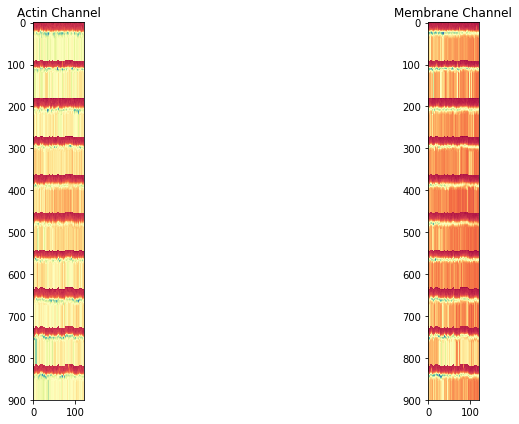

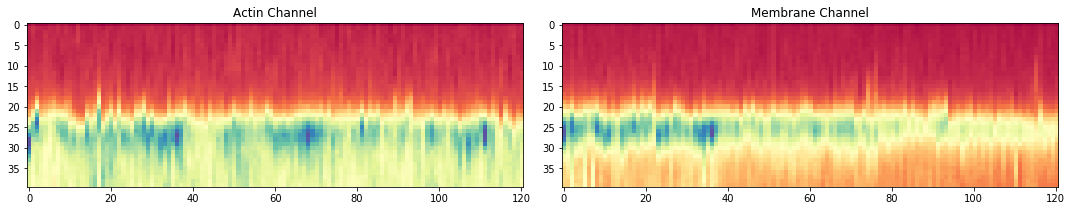

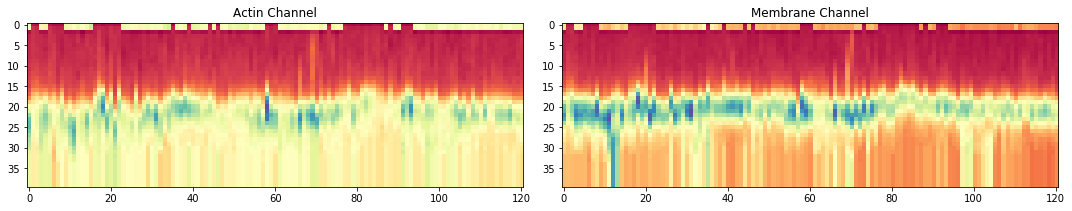

KeyboardInterrupt: 

In [14]:
Actin = imread(Actinimage)
Membrane = imread(Membraneimage)

doubleplot(Actin, Membrane, 'Actin Channel', 'Membrane Channel')
blockimageActin = []
blockimageMembrane = []

i = 0
while i < Actin.shape[0]:
       
   blockActin = Actin[i:i + singleblock,:]#/np.amax(Actin[i:i + singleblock,:], 0)
   blockMembrane = Membrane[i:i + singleblock,:]#/np.amax(Membrane[i:i + singleblock,:],0)
   
   blockimageActin.append(blockActin)
   blockimageMembrane.append(blockMembrane)
   doubleplot(blockActin, blockMembrane, 'Actin Channel', 'Membrane Channel')
   i = i + singleblock + skip 

halflength = int(len(blockimageActin)/2)
otherhalf = len(blockimageActin) - halflength
totallength = len(blockimageActin)


In [ ]:
%%time
#Fit all blocks
global Thickness,Intensity,PeakActin,DataActin,PeakMembrane,DataMembrane,Time,ID,BlockAverageActin,BlockAverageMembrane
Thickness = []
Intensity = []
PeakActin = []
DataActin = []
PeakMembrane = []
DataMembrane = []
Time = []
ID = []

BlockAverageActin = []
BlockAverageMembrane = []
for i in range(0, 2):
    
 BlockActin = []
 BlockMembrane = []
    
 print('block id', i+1) 
 currentid = i+1
 ID.append(i + 1)
 Actin = blockimageActin[i]
 Membrane = blockimageMembrane[i]
 
 StripFit(Membrane, Actin, Time_unit, Xcalibration, Fitaround, psf, inisigmaguess, showaftertime, Thickness, Intensity, PeakActin, BlockActin, PeakMembrane, BlockMembrane, BlockAverageActin,BlockAverageMembrane, Time, 0)
 Correlation_plot(Thickness, Intensity, ID)
 
 print("Thickness (min)",np.min(Thickness) *1000, "nm")
 print("Thickness (median)",np.median(Thickness) *1000, "nm")
 print("Thickness (max)",np.max(Thickness) *1000, "nm")
 
 Thickness_intensity = np.column_stack([Thickness, Intensity]) 
 
 Thickness_id = np.column_stack([Thickness, ID]) 
 

 #clear_output(wait = True)
    
print(Thickness)
hist, edges = np.histogram((Thickness), density=False, bins='auto')
p = figure(title="Estimated Cortex Thickness = " + str('%.5f'%np.abs(edges[np.argmax(hist)] * 1000)) + 'nm', y_axis_label='Counts',x_axis_label='Thickness(um)')
listedges = edges.tolist()
listhist = hist.tolist()
output_notebook()
p.quad(top=hist, bottom=0, left=edges[:-1], right=edges[1:],
    fill_color="#036564", line_color="#033649")
for  i in range(0,len(listhist)):
  if listhist[i] > 0:
   mytext = Label(x=listedges[i], y=listhist[i], text=str('%.4f'%listedges[i]))
   p.add_layout(mytext)
show(p)

master_data= []

Path(save_dir).mkdir(exist_ok = True)

for line in Thickness_id:
    master_data.append(line)
writer = csv.writer(open(save_dir + "/" + (os.path.basename(Actinimage))  +".csv", "w"))
writer.writerows(master_data) 

num_clusters = 2
show_intensity_plot(Thickness_intensity, ymin = 0, ymax = 0.5, num_clusters = num_clusters )



FinalThickness = []
FinalIntensity = []
FinalTime = []
FinalShiftFit(BlockAverageActin, BlockAverageMembrane, Time_unit, Xcalibration, Fitaround
             , psf, inisigmaguess, showaftertime,FinalThickness, FinalIntensity,   FinalTime, 0)
  